<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/regresion_planta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Cargando librerias para realizar el modelo de regresion lineal
import pandas as pd
import numpy as np

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error


In [ ]:
## Cargando el dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(filename)
df = pd.read_excel(filename)
df.head()
df.columns


In [ ]:
## Limpieza inicial de dataset
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
)
df.columns

## limpieza final de dataset
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace('%', 'pct', regex=False)
    .str.replace('.', '', regex=False)
)
df.columns


In [ ]:
## Definición de variables del modelo
## variable target
y = df['molido_kt'] #en este primer modelo, vamos a predecir la producción o tonelaje molido
#ceros = dia sin produccion NO SE ELIMINA, NO SE IMPUTAN
y.isna().sum() #verifica NaN
y[y.isna()].head() #Identifica los NaN
mask = ~y.isna() #Selecciona los NaN
y = y.loc[mask] #Quita filas con NaN
y.isna().sum() #Verifica que no hay NaN

## variables explicativas (predictores)
features = [
    'disponibilidad_chancado_pct',
    'uso_de_disponibilidad_chancado_pct',
    'disponibilidad_molienda_pct',
    'uso_de_disponibilidad_molienda_pct',
    'stock_pile_pct',
    'tonelaje_stock_pile_kt'
]

X = df[features]

##conversion segura
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

##Revision de nulos
X.isna().sum()

##Impuracion en X (medianas)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X = pd.DataFrame(
    imputer.fit_transform(X),
    columns=features
)
## evita el error de NaN, respeta dias sin produccion
X = X.loc[mask]

In [ ]:
##Dataset para entranamiento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [ ]:
## Entrenamiento del modelo
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


In [ ]:
## Evaluacion del modelo
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2   : {r2:.3f}")
print(f"MAE  : {mae:.2f} kt")
print(f"RMSE : {rmse:.2f} kt")



In [ ]:
## Ecuacion del modelo
intercepto = model.intercept_
coeficientes = pd.Series(model.coef_, index=features)

intercepto, coeficientes
coeficientes.sort_values(ascending=False)

In [ ]:
##Grafica de datos predecidos y reales
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Molido real (kt)")
plt.ylabel("Molido predicho (kt)")
plt.title("Real vs Predicho")
plt.show()

In [ ]:
##Analisis de residuales
residuos = y_test - y_pred
plt.figure()
plt.hist(residuos, bins=30)
plt.xlabel("Error (kt)")
plt.title("Distribución de residuos")
plt.show()

##Residuos vs prediccion
plt.figure()
plt.scatter(y_pred, residuos)
plt.axhline(0)
plt.xlabel("Molido predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción")
plt.show()

In [ ]:
##Predicciones
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Observado', marker='')
plt.plot(y_pred_test, label='Predicho', marker='')
plt.legend()
plt.title('Serie Observada vs Predicha')
plt.xlabel('Índice')
plt.ylabel('Real diario')
plt.show()

In [ ]:
##Importancia relativa
coef = pd.Series(model.coef_, index=features)
intercept = model.intercept_
coef, intercept

coef.sort_values().plot(kind='barh')
plt.title('Impacto relativo de variables')
plt.show()

In [ ]:
df_eval = X_test.copy()
df_eval['real'] = y_test.values
df_eval['pred'] = y_pred

df_eval['error'] = df_eval['pred'] - df_eval['real']

df_eval.groupby(
    pd.cut(df_eval['real'], bins=5)
)['error'].agg(['mean', 'std', 'count'])


In [ ]:
## Implementacion del modelo por regimenes de molienda
df.columns = (
    df.columns
      .str.lower()
      .str.strip()
      .str.replace('%', 'pct')
      .str.replace('(', '', regex=False)
      .str.replace(')', '', regex=False)
      .str.replace('.', '', regex=False)
      .str.replace(' ', '_')
)

df.columns

df['regimen'] = np.select(
    [
        df['uso_de_disponibilidad_molienda_pct'] < 70,
        (df['uso_de_disponibilidad_molienda_pct'] >= 70) &
        (df['uso_de_disponibilidad_molienda_pct'] < 85)
    ],
    [
        'Bajo uso molienda',
        'Uso medio molienda'
    ],
    default='Alto uso molienda'
)

df['regimen'].value_counts()

##Validando que los regimenes existan
df.groupby('regimen')['real_diario'].agg(['mean','std','count'])


In [ ]:
##Repetir analisis de errores por regimen
df_eval = X_test.copy()
df_eval['real'] = y_test.values
df_eval['pred'] = y_pred
df_eval['error'] = df_eval['pred'] - df_eval['real']

df_eval = df_eval.merge(
    df[['regimen']],
    left_index=True,
    right_index=True
)

df_eval.groupby(
    ['regimen', pd.cut(df_eval['real'], bins=5)]
)['error'].agg(['mean','std','count'])


In [ ]:
##Definir alto uso de molienda
print(df.columns.tolist())

df['regimen'].value_counts()

df_eval = X_test.copy()
df_eval['real'] = y_test.values
df_eval['pred'] = y_pred
df_eval['error'] = df_eval['pred'] - df_eval['real']
df_eval['regimen'] = df.loc[X_test.index, 'regimen']

resultado = (
    df_eval
    .groupby(
        ['regimen', pd.cut(df_eval['real'], bins=6)]
    )['error']
    .agg(['mean', 'std', 'count'])
)

resultado



In [ ]:
##Modelos por umbrales
umbral = 120  # kt

df[['real_diario']].head()
df['real_diario'].dtype

target = 'molido_kt'
umbral = 120  # kt

df['regimen_prod'] = np.where(
    df[target] >= umbral,
    'Alta carga',
    'Baja carga'
)

df['regimen_prod'].value_counts() #validando los regimenes

df.groupby('regimen_prod')[target].describe()

df['regimen_prod'].value_counts()


In [ ]:
##Separar datasets por regimenes
target = 'molido_kt'

features = [
    'disponibilidad_chancado_pct',
    'uso_de_disponibilidad_chancado_pct',
    'disponibilidad_molienda_pct',
    'uso_de_disponibilidad_molienda_pct',
    'stock_pile_pct',
    'tonelaje_stock_pile_kt'
]

df_alta = df[df['regimen_prod'] == 'Alta carga'].copy()
df_baja = df[df['regimen_prod'] == 'Baja carga'].copy()

print(df_alta.shape, df_baja.shape)


In [ ]:
##Entranamiento de ambos modelos
features = [
    'disponibilidad_chancado_pct',
    'uso_de_disponibilidad_chancado_pct',
    'disponibilidad_molienda_pct',
    'uso_de_disponibilidad_molienda_pct',
    'stock_pile_pct',
    'tonelaje_stock_pile_kt'
]

target = 'molido_kt'

cols_modelo = features + [target]

df_model = df.copy()

df_model[cols_modelo] = (
    df_model[cols_modelo]
    .replace('-', np.nan)
    .astype(float)
)

print("Antes:", df_model.shape)

df_model = df_model.dropna(subset=cols_modelo)

print("Después:", df_model.shape)

##Volver a separar regimenes
df_alta = df_model[df_model['regimen_prod'] == 'Alta carga'].copy()
df_baja = df_model[df_model['regimen_prod'] == 'Baja carga'].copy()

print(df_alta.shape, df_baja.shape)




In [ ]:
##Train/split por regimen
## alta carga
from sklearn.model_selection import train_test_split

X_alta = df_alta[features]
y_alta = df_alta[target]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_alta, y_alta, test_size=0.25, random_state=42
)

##baja carga
X_baja = df_baja[features]
y_baja = df_baja[target]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_baja, y_baja, test_size=0.25, random_state=42
)


In [ ]:
##Entranamiento de ambos modelos
from sklearn.linear_model import LinearRegression

model_alta = LinearRegression()
model_baja = LinearRegression()

model_alta.fit(X_train_a, y_train_a)
model_baja.fit(X_train_b, y_train_b)



In [ ]:
##Metricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def metricas(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

pred_a = model_alta.predict(X_test_a)
pred_b = model_baja.predict(X_test_b)

met_alta = metricas(y_test_a, pred_a)
met_baja = metricas(y_test_b, pred_b)

met_alta, met_baja


In [ ]:
##Patron de errores
res_a = y_test_a - pred_a
res_b = y_test_b - pred_b

import matplotlib.pyplot as plt

plt.scatter(pred_a, res_a, alpha=0.3)
plt.axhline(0, color="red")
plt.title("Residuos – Alta carga")
plt.show()

plt.scatter(pred_b, res_b, alpha=0.3)
plt.axhline(0, color="red")
plt.title("Residuos – Baja carga")
plt.show()


In [ ]:
##Ejemplo de prediccion (solo en alto uso de molienda)
model_alta.feature_names_in_

X_new = pd.DataFrame([{
    "disponibilidad_chancado_pct": 92,
    "uso_de_disponibilidad_chancado_pct": 88,
    "disponibilidad_molienda_pct": 95,
    "uso_de_disponibilidad_molienda_pct": 90,
    "stock_pile_pct": 12,
    "tonelaje_stock_pile_kt": 180
}])

# Garantiza mismo orden que el entrenamiento
X_new = X_new[model_alta.feature_names_in_]

pred = model_alta.predict(X_new)
print(f"Producción esperada ≈ {pred[0]:.1f} kt/día")



In [ ]:
##Simulacion de escenarios
escenarios = []
for uso_mol in [80, 85, 90, 95]:
    X_tmp = X_new.copy()
    X_tmp["uso_de_disponibilidad_molienda_pct"] = uso_mol
    escenarios.append((uso_mol, model_alta.predict(X_tmp)[0]))

pd.DataFrame(escenarios, columns=["uso_molienda_pct", "produccion_kt"])


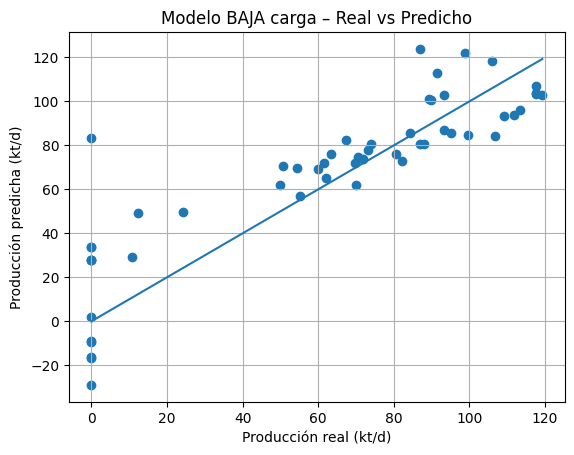

In [91]:
##Inspeccion visual de ambos modelos
# Predicciones
[k for k in globals().keys() if 'baja' in k.lower() or 'alta' in k.lower()]

from sklearn.model_selection import train_test_split

# BAJA carga
X_train_baja, X_test_baja, y_train_baja, y_test_baja = train_test_split(
    X_baja, y_baja, test_size=0.2, random_state=42
)

# ALTA carga
X_train_alta, X_test_alta, y_train_alta, y_test_alta = train_test_split(
    X_alta, y_alta, test_size=0.2, random_state=42
)

from sklearn.linear_model import LinearRegression

model_baja = LinearRegression()
model_alta = LinearRegression()

model_baja.fit(X_train_baja, y_train_baja)
model_alta.fit(X_train_alta, y_train_alta)

y_pred_baja = model_baja.predict(X_test_baja)
y_pred_alta = model_alta.predict(X_test_alta)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def metricas(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

met_baja = metricas(y_test_baja, y_pred_baja)
met_alta = metricas(y_test_alta, y_pred_alta)

met_baja, met_alta

##grafico visual
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test_baja, y_pred_baja)
plt.plot(
    [y_test_baja.min(), y_test_baja.max()],
    [y_test_baja.min(), y_test_baja.max()]
)
plt.xlabel("Producción real (kt/d)")
plt.ylabel("Producción predicha (kt/d)")
plt.title("Modelo BAJA carga – Real vs Predicho")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(y_test_alta, y_pred_alta)
plt.plot(
    [y_test_alta.min(), y_test_alta.max()],
    [y_test_alta.min(), y_test_alta.max()]
)
plt.xlabel("Producción real (kt/d)")
plt.ylabel("Producción predicha (kt/d)")
plt.title("Modelo ALTA carga – Real vs Predicho")
plt.grid(True)
plt.show()


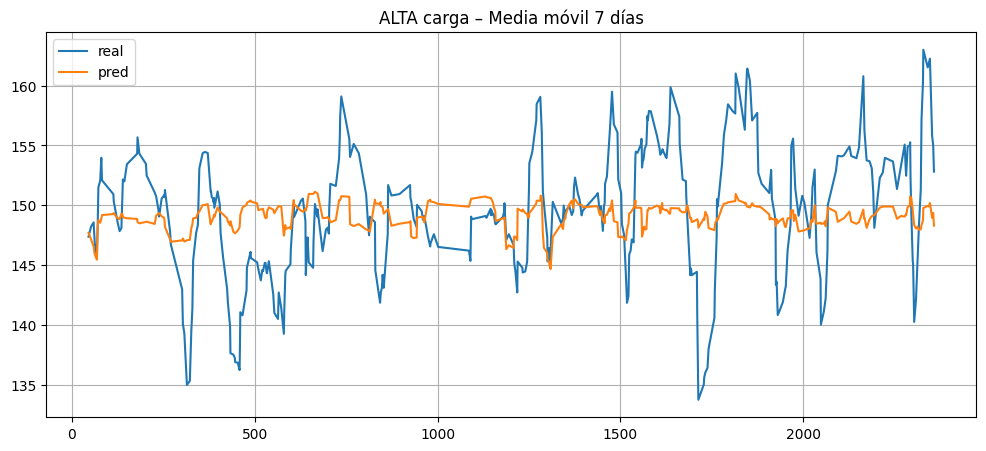

In [97]:
df_eval_baja = X_test_baja.copy()
df_eval_baja["real"] = y_test_baja.values
df_eval_baja["pred"] = y_pred_baja

df_eval_baja = df_eval_baja.sort_index()

df_eval_alta = X_test_alta.copy()
df_eval_alta["real"] = y_test_alta.values
df_eval_alta["pred"] = y_pred_alta

df_eval_alta = df_eval_alta.sort_index()

##baja carga
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_eval_baja.index, df_eval_baja["real"], label="Real")
plt.plot(df_eval_baja.index, df_eval_baja["pred"], label="Predicho")
plt.title("Producción – BAJA carga")
plt.xlabel("Tiempo")
plt.ylabel("Producción (kt/día)")
plt.legend()
plt.grid(True)
plt.show()

##alta carga
plt.figure(figsize=(12,5))
plt.plot(df_eval_alta.index, df_eval_alta["real"], label="Real")
plt.plot(df_eval_alta.index, df_eval_alta["pred"], label="Predicho")
plt.title("Producción – ALTA carga")
plt.xlabel("Tiempo")
plt.ylabel("Producción (kt/día)")
plt.legend()
plt.grid(True)
plt.show()

#mejora
df_eval_alta[["real","pred"]].rolling(7).mean().plot(figsize=(12,5))
plt.title("ALTA carga – Media móvil 7 días")
plt.grid(True)
plt.show()
